# <center> UNSW-NB15 Dataset Preprocessing Notebook <center/>

Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import pandas_profiling , pickle
import matplotlib.pyplot as plt
%matplotlib inline
from preprocessing import get_data

from sklearn.preprocessing import StandardScaler, RobustScaler,power_transform
from scipy.stats import skew

## Read data and do Profiling

In [2]:
train,test, label_mapping = get_data()

profile = pandas_profiling.ProfileReport(train)
# profile.to_file(outputfile="UNSW profile report.html")

Remove rejected features

In [3]:
to_remove = profile.get_rejected_variables()
train.drop(to_remove, axis=1, inplace=True)

data ,y_train = train.drop(["label","attack_cat"],axis=1),train.label.values

label_cols = ['label']
data_cols = list(data.columns)

In [4]:
def Plot_data_features(data_cols, X, y = None):
    """"Helper method to plot Dataset features distributions using histograms"""
    axarr = [[]]*len(data_cols)
    columns = 4
    rows = int( np.ceil( len(data_cols) / columns ) )
    f, fig = plt.subplots( figsize=(columns*3.5, rows*2) )

    f.suptitle('Data Distributions by Feature and Class', size=16)

    for i, col in enumerate(data_cols[:]):
        axarr[i] = plt.subplot2grid( (int(rows), int(columns)), (int(i//columns), int(i%columns)) )
        axarr[i].hist( [ X.loc[ y == 1, col ], X.loc[ y != 1, col ] ], label=['Normal','Attack'], 
                              bins=np.linspace( np.percentile(X[col],0.1), np.percentile(X[col],99.9), 30 ),
                              normed=True )
        axarr[i].set_xlabel(col, size=12)
        axarr[i].set_ylim([0,0.8])
        axarr[i].tick_params(axis='both', labelsize=10)
        if i == 0: 
            legend = axarr[i].legend()
            legend.get_frame().set_facecolor('white')
        if i%4 != 0 : 
            axarr[i].tick_params(axis='y', left='off', labelleft='off')
        else:
            axarr[i].set_ylabel('Fraction',size=12)

    plt.tight_layout(rect=[0,0,1,0.95]) 
    plt.show()

## <center> Scale & Transform Data <center/>

### Robust Scaler
Scale features using statistics that are robust to outliers. 
This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 10th quantile and the 3rd quartile 99th quantile.

In [5]:
data_Robust_trans = pd.DataFrame(data=RobustScaler(quantile_range=(0.1, 99.9 )).fit_transform(data[data_cols].values),columns=list(data.columns))
data_Robust_trans.head()

,dur,proto,service,state,spkts,dpkts,rate,sttl,dttl,sload,...,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,is_ftp_login,ct_flw_http_mthd,ct_src_ltm
0,0.001999,-0.007634,0.000000,-0.25,0.005057,0.002331,-0.003152,-0.007874,0.892857,-0.000406,...,-0.022901,-0.000686,0.0,0.0,-0.08,-0.166667,-0.022727,0.0,0.0,-0.044444
1,0.010809,-0.007634,0.000000,-0.25,0.015171,0.041958,-0.003147,-0.755906,0.884921,-0.000409,...,-0.016031,0.728395,0.0,0.0,0.76,0.000000,-0.022727,0.0,0.0,-0.044444
2,0.027035,-0.007634,0.000000,-0.25,0.007585,0.016317,-0.003212,-0.755906,0.884921,-0.000412,...,-0.020611,0.534979,0.0,0.0,0.04,0.000000,0.000000,0.0,0.0,-0.022222
3,0.028011,-0.007634,0.111111,-0.25,0.012642,0.011655,-0.003212,-0.755906,0.884921,-0.000411,...,-0.016031,0.013717,0.0,0.0,-0.08,0.000000,0.000000,1.0,0.0,-0.022222
4,0.007467,-0.007634,0.000000,-0.25,0.010114,0.004662,-0.003192,0.000000,0.884921,-0.000409,...,-0.015267,0.000686,0.0,0.0,0.76,0.000000,0.000000,0.0,0.0,-0.022222


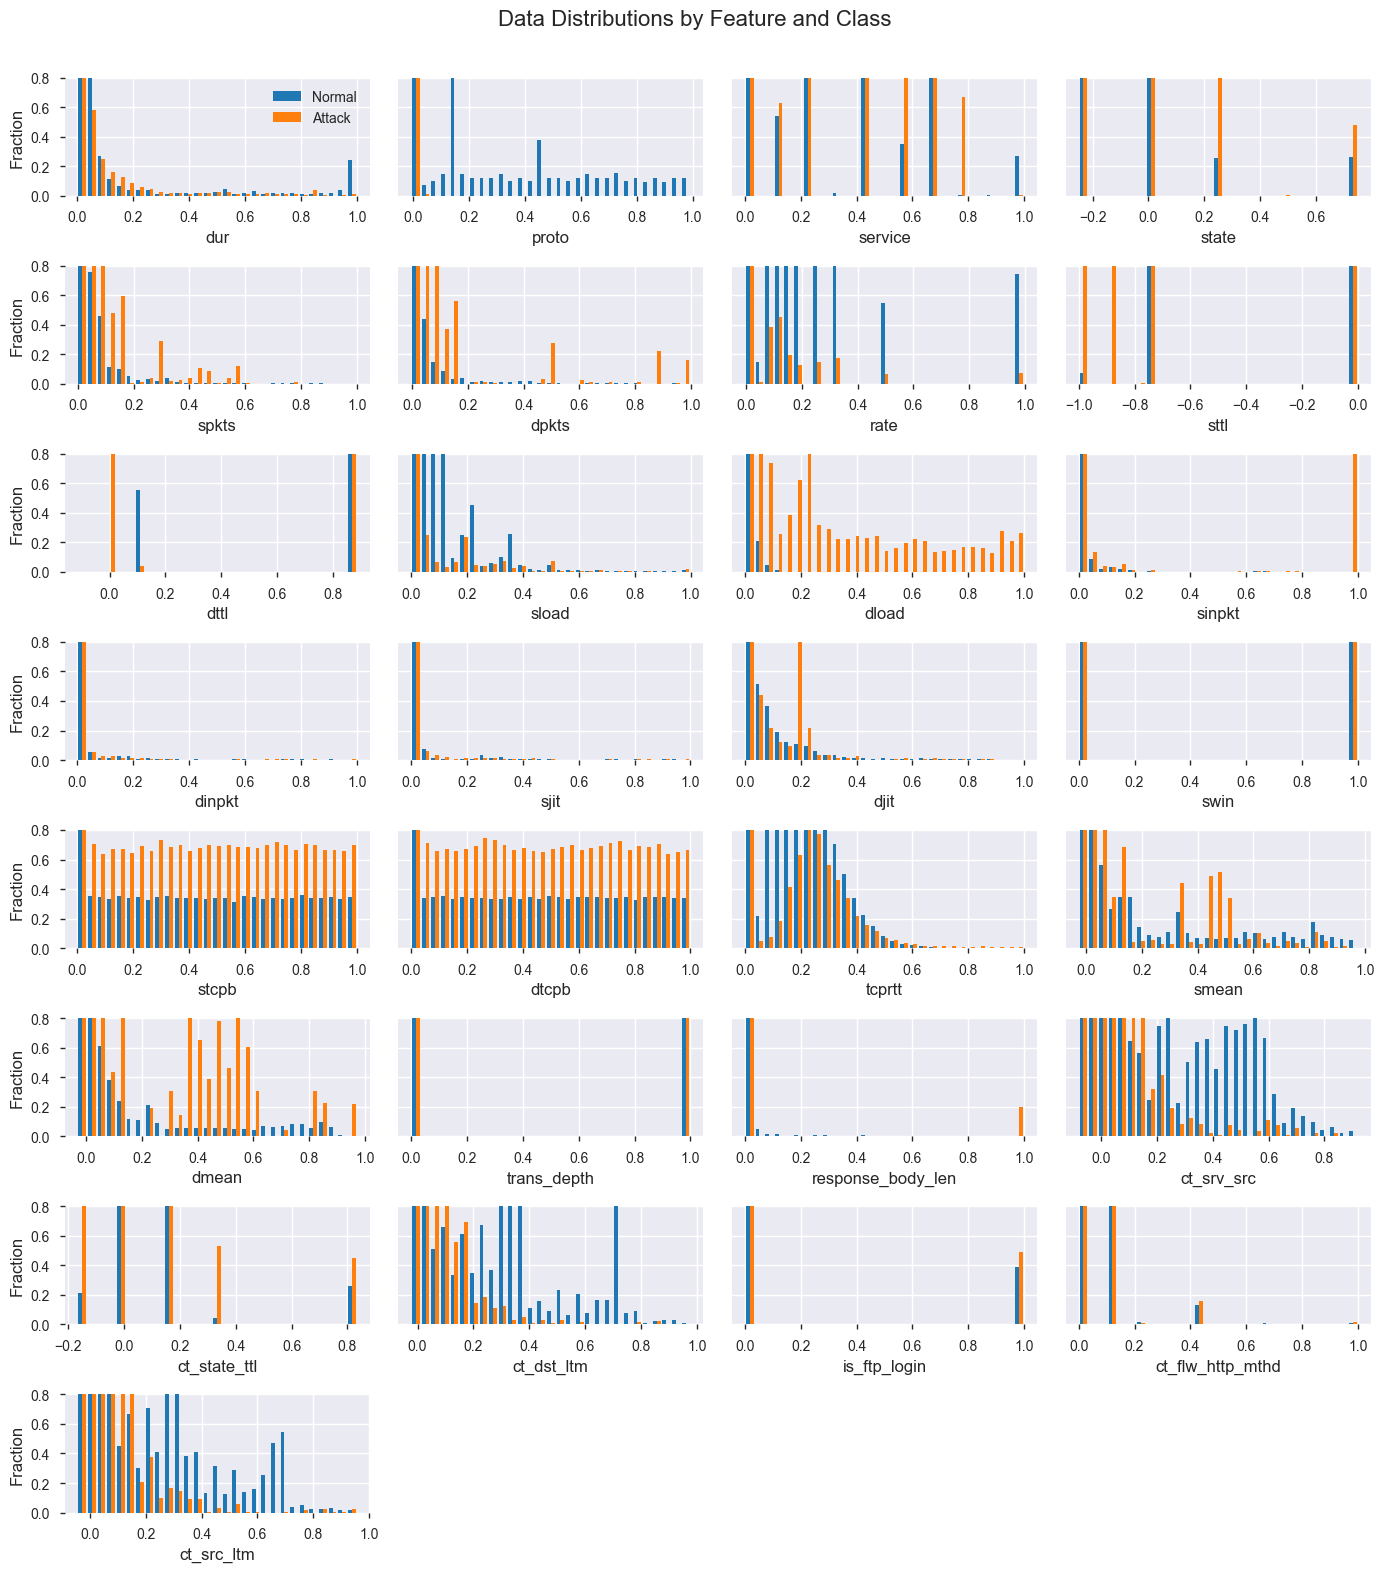

In [6]:
Plot_data_features(X=data_Robust_trans,data_cols=data_cols,y=y_train)

In [7]:
data_Robust_trans["label"] = y_train 
with open('../Data/UNSW-NB15/data_Robust_trans.pickle', 'wb') as f:
    pickle.dump(data_Robust_trans,f)

## Power Transform

In [8]:
data_power_trans = pd.DataFrame(data=power_transform(X=data.values,method="yeo-johnson"),columns=list(data.columns))
# data_power_trans.describe()
data_power_trans.head()

,dur,proto,service,state,spkts,dpkts,rate,sttl,dttl,sload,...,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,is_ftp_login,ct_flw_http_mthd,ct_src_ltm
0,-0.198694,-0.91809,-0.904939,-1.071008,0.222781,0.386101,-0.886597,0.704082,1.259365,-0.986806,...,-1.953675,0.587295,-0.336555,-0.262385,-1.370661,-1.515026,-1.145736,-0.121892,-0.336555,-1.279673
1,0.995349,-0.91809,-0.904939,-1.071008,0.882238,1.383878,-0.874725,-1.124046,1.256852,-1.075737,...,-1.140630,1.615158,-0.336555,-0.262385,1.740536,-0.224801,-1.145736,-0.121892,-0.336555,-1.279673
2,1.618843,-0.91809,-0.904939,-1.071008,0.470300,1.054254,-1.209509,-1.124046,1.256852,-1.343700,...,-1.644611,1.531983,-0.336555,-0.262385,0.361515,-0.224801,-0.351918,-0.121892,-0.336555,-0.560046
3,1.636531,-0.91809,-0.078885,-1.071008,0.777863,0.928489,-1.215951,-1.124046,1.256852,-1.257635,...,-1.140630,0.726105,-0.336555,-0.262385,-1.370661,-0.224801,-0.351918,8.204011,-0.336555,-0.560046
4,0.691451,-0.91809,-0.904939,-1.071008,0.645553,0.595491,-1.047114,0.722657,1.256852,-1.072445,...,-1.068528,0.603326,-0.336555,-0.262385,1.740536,-0.224801,-0.351918,-0.121892,-0.336555,-0.560046


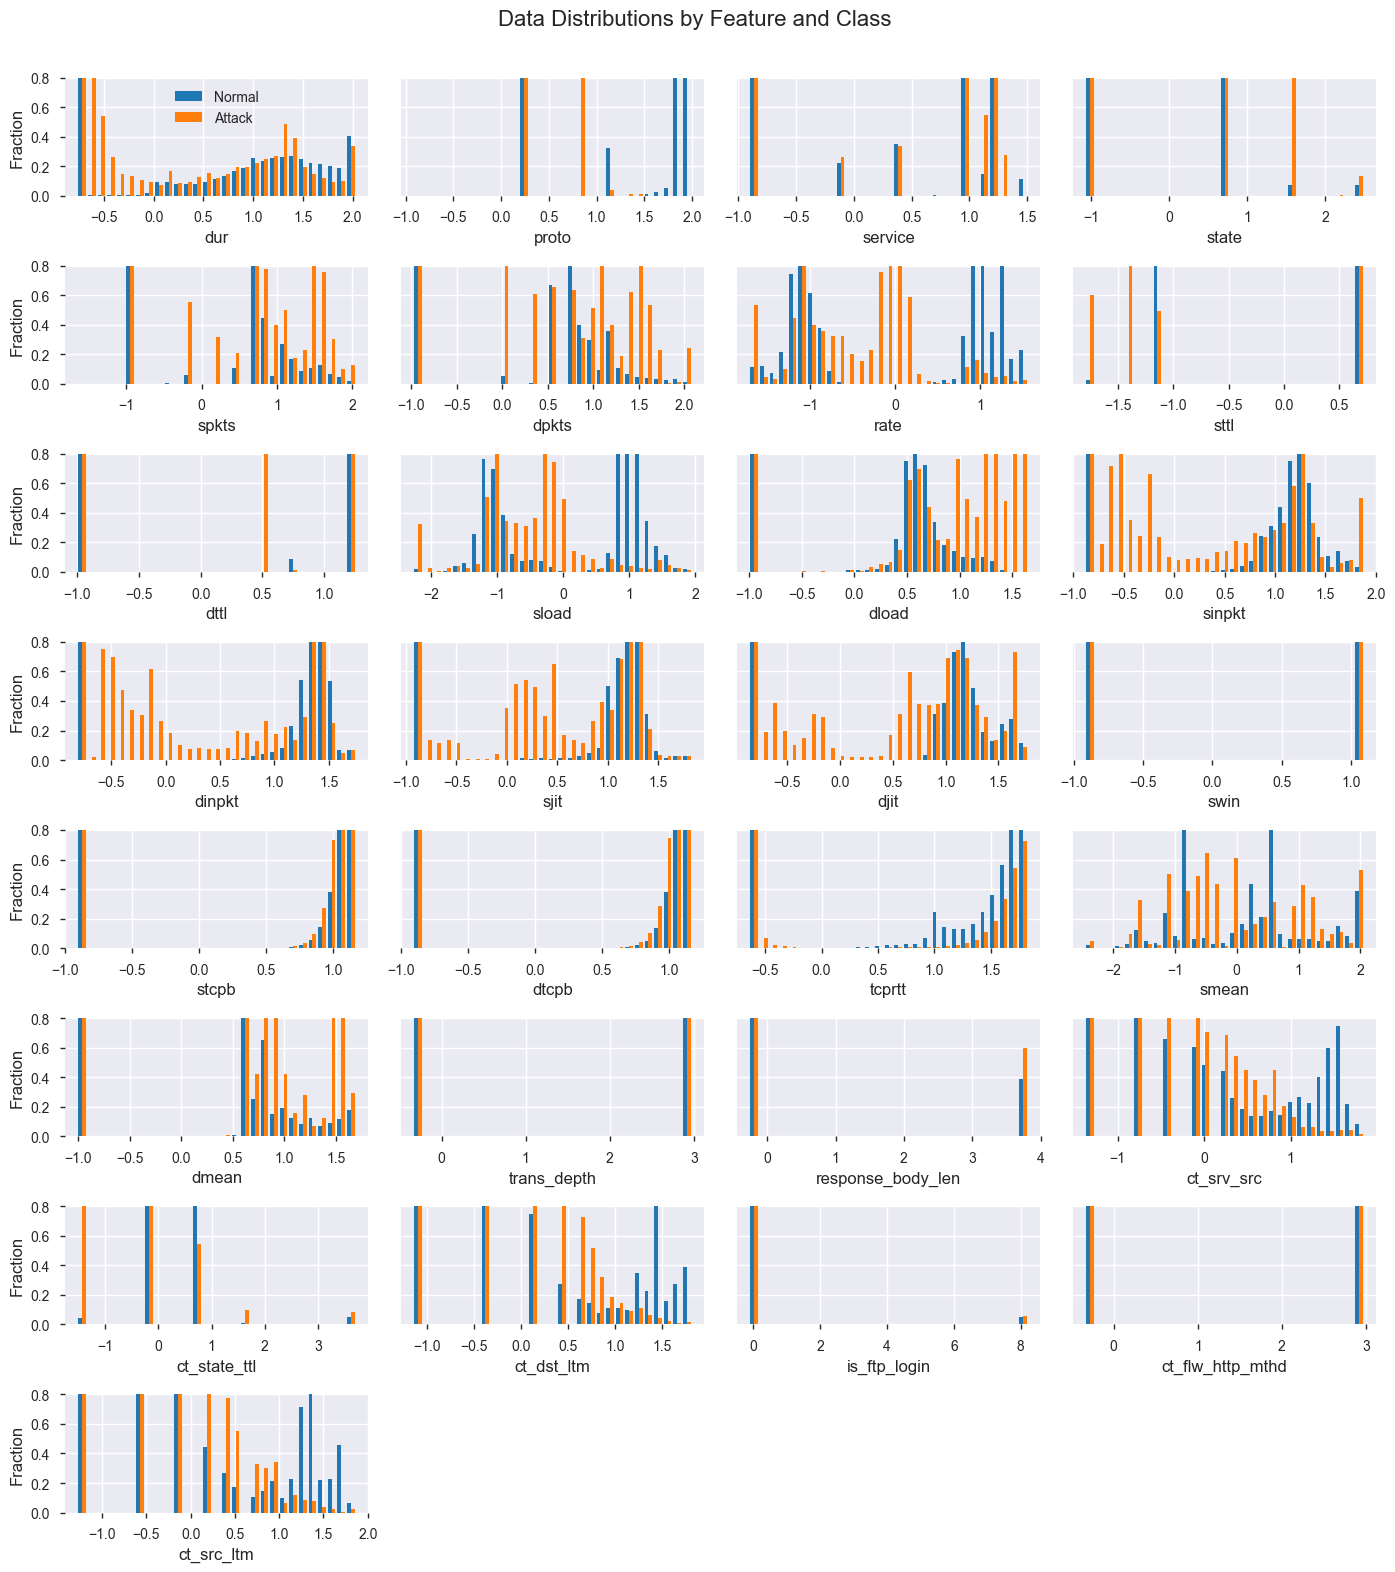

In [9]:
Plot_data_features(X=data_power_trans,data_cols=data_cols,y=y_train)

In [10]:
# Dump New dataset to pickle file
data_power_trans["label"] = y_train 
with open('../Data/UNSW-NB15/data_power_trans.pickle', 'wb') as f:
    pickle.dump(data_power_trans,f)

### Standard Scaler

In [11]:
data_std = StandardScaler().fit_transform(data.values)
data_std = pd.DataFrame(data=data_std,columns=list(data.columns))
data_std.head()

,dur,proto,service,state,spkts,dpkts,rate,sttl,dttl,sload,...,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,is_ftp_login,ct_flw_http_mthd,ct_src_ltm
0,-0.191029,-0.352112,-0.857585,-0.926459,-0.104456,-0.135769,-0.576371,0.703839,1.578100,-0.389897,...,-0.458048,-0.314240,-0.136415,-0.039557,-0.775991,-1.366486,-0.645013,-0.118590,-0.189768,-0.715714
1,-0.109485,-0.352112,-0.857585,-0.926459,-0.046014,0.172599,-0.576345,-1.141901,1.560002,-0.389928,...,-0.414076,3.800869,-0.136415,-0.039557,3.147666,-0.318711,-0.645013,-0.118590,-0.189768,-0.715714
2,0.040699,-0.352112,-0.857585,-0.926459,-0.089845,-0.026933,-0.576734,-1.141901,1.560002,-0.389964,...,-0.443391,2.709185,-0.136415,-0.039557,-0.215468,-0.318711,-0.520827,-0.118590,-0.189768,-0.595543
3,0.049729,-0.352112,-0.493872,-0.926459,-0.060624,-0.063212,-0.576737,-1.141901,1.560002,-0.389958,...,-0.414076,-0.232945,-0.136415,-0.039557,-0.775991,-0.318711,-0.520827,7.814915,-0.189768,-0.595543
4,-0.140417,-0.352112,-0.857585,-0.926459,-0.075235,-0.117630,-0.576617,0.723268,1.560002,-0.389927,...,-0.409190,-0.306498,-0.136415,-0.039557,3.147666,-0.318711,-0.520827,-0.118590,-0.189768,-0.595543


In [12]:
data_std.describe()

,dur,proto,service,state,spkts,dpkts,rate,sttl,dttl,sload,...,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,is_ftp_login,ct_flw_http_mthd,ct_src_ltm
count,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,...,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05,1.753410e+05
mean,-3.566066e-18,8.688234e-17,5.705706e-17,1.945127e-16,-1.426426e-17,5.187005e-18,-3.241878e-17,-1.607972e-16,-1.141141e-16,1.167076e-17,...,-1.491264e-17,-1.815452e-17,-2.139640e-17,9.117783e-18,4.408955e-17,2.593503e-17,1.115206e-16,-6.483757e-18,-5.187005e-18,3.630904e-17
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,...,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,-2.097747e-01,-3.521120e-01,-8.575849e-01,-9.264591e-01,-1.409822e-01,-1.720474e-01,-5.768192e-01,-1.744196e+00,-7.204059e-01,-3.899726e-01,...,-5.313342e-01,-4.807028e-01,-1.364151e-01,-3.955687e-02,-7.759906e-01,-1.366486e+00,-6.450129e-01,-1.185902e-01,-1.897681e-01,-7.157137e-01
25%,-2.097735e-01,-3.521120e-01,-8.575849e-01,-9.264591e-01,-1.336769e-01,-1.720474e-01,-5.766210e-01,-1.141901e+00,-7.204059e-01,-3.899033e-01,...,-3.896474e-01,-4.807028e-01,-1.364151e-01,-3.955687e-02,-6.825702e-01,-3.187109e-01,-6.450129e-01,-1.185902e-01,-1.897681e-01,-5.955426e-01
50%,-2.095306e-01,-3.054935e-01,-8.575849e-01,4.617925e-01,-1.336769e-01,-1.539081e-01,-5.573162e-01,7.232680e-01,-4.579780e-01,-3.853023e-01,...,-3.114753e-01,-3.103690e-01,-1.364151e-01,-3.955687e-02,-4.023091e-01,-3.187109e-01,-5.208272e-01,-1.185902e-01,-1.897681e-01,-4.753715e-01
75%,-1.066813e-01,-3.054935e-01,1.324692e+00,4.617925e-01,-6.062410e-02,-8.135096e-02,1.789221e-01,7.232680e-01,1.560002e+00,8.194472e-02,...,-1.795600e-01,-1.361640e-01,-1.364151e-01,-3.955687e-02,2.516337e-01,7.290641e-01,1.001016e-01,-1.185902e-01,-1.897681e-01,2.456551e-01
max,9.049154e+00,5.801534e+00,3.506969e+00,1.017955e+01,7.009933e+01,9.935819e+01,5.469112e+00,7.329824e-01,1.578100e+00,3.140074e+01,...,6.680036e+00,5.163540e+00,2.212539e+02,1.209403e+02,5.016074e+00,4.920164e+00,5.564275e+00,3.161543e+01,4.259369e+01,6.374381e+00


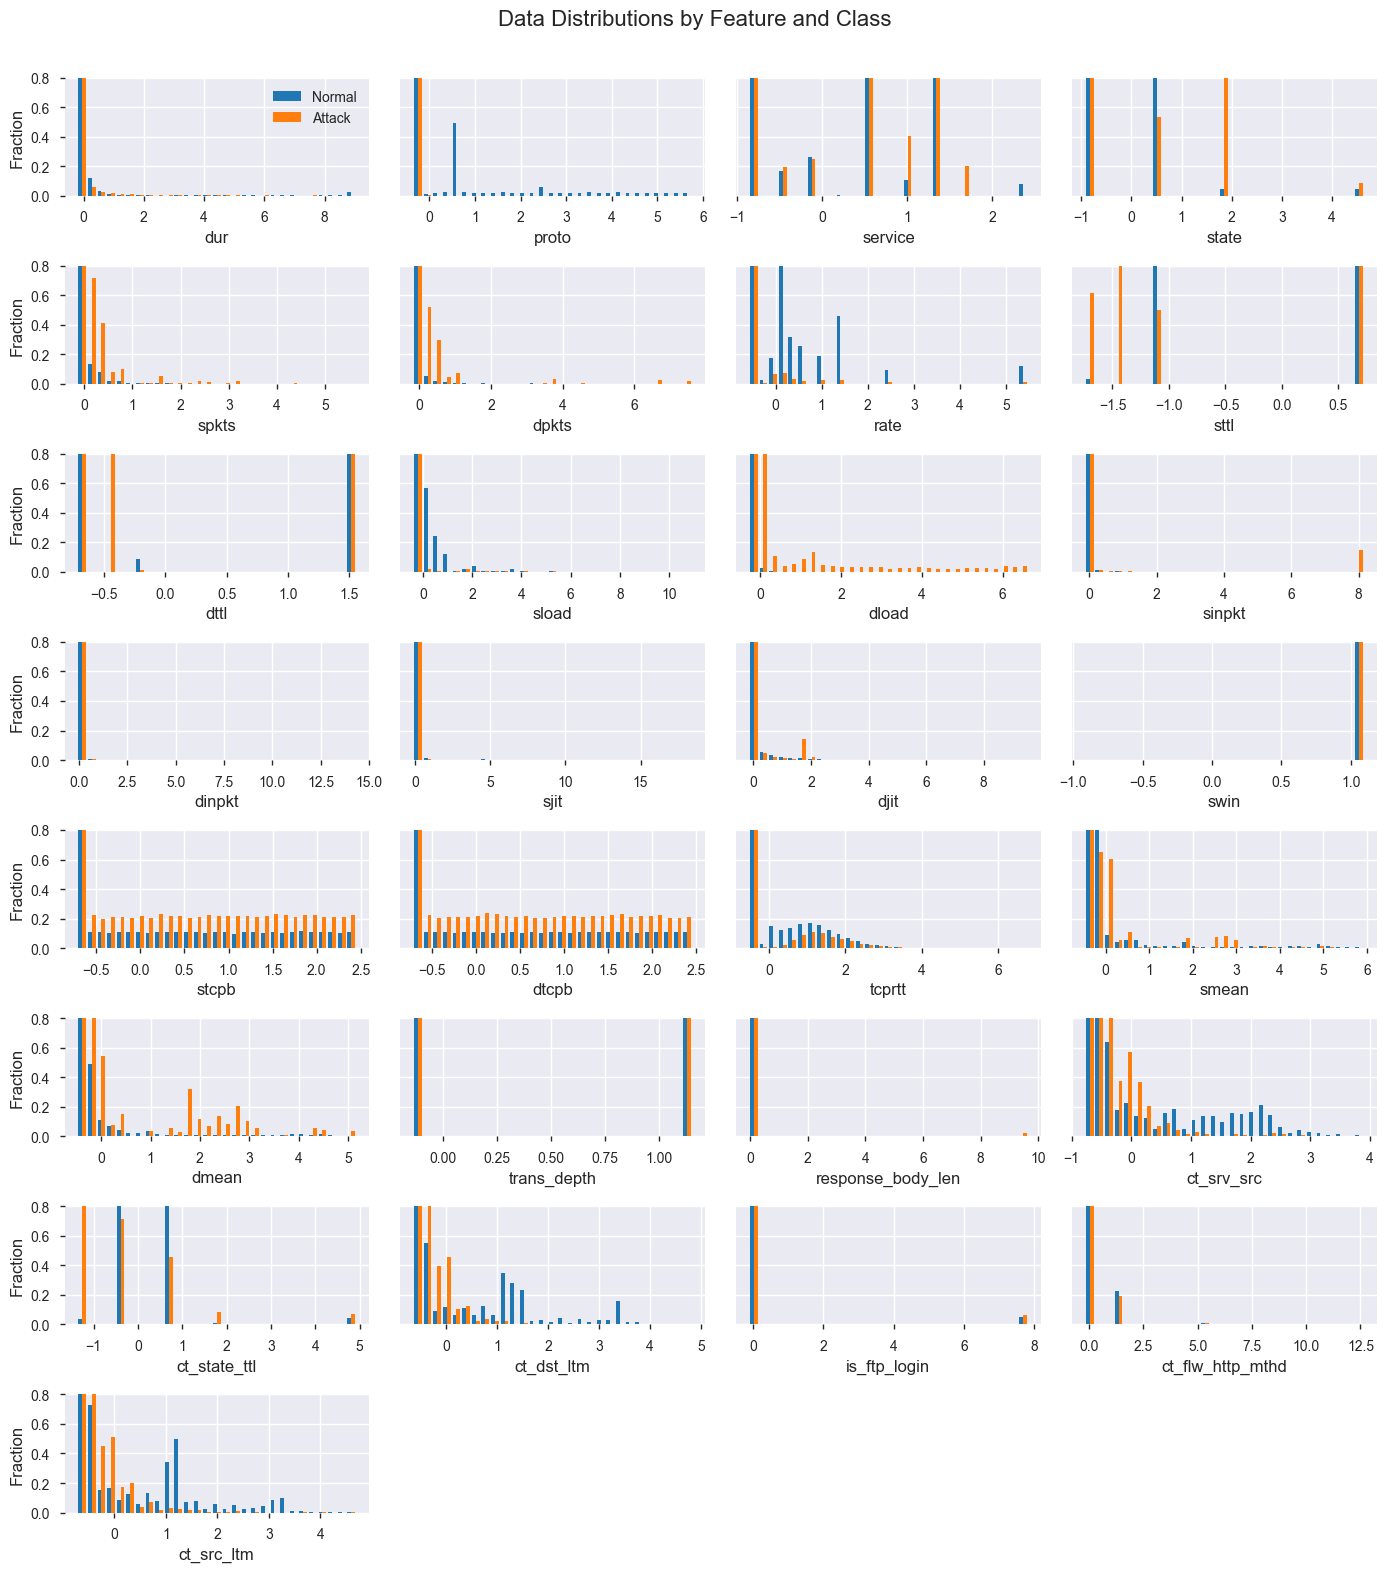

In [13]:
Plot_data_features(X= data_std, data_cols= data_cols, y= y_train)

In [14]:
# Dump New dataset to pickle file
data_std["label"] = y_train 
with open('../Data/UNSW-NB15/data_std.pickle', 'wb') as f:
    pickle.dump(data_std,f)